<h3 style="color:gold">Importing the Necessary Libraries</h3>
<h5>I have prepared some custom functions in ../src/utils.py</h5>

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# import custom functions from src/utils.py
import sys
sys.path.append('../')
from src.utils import remove_correlated_features
from src.utils import plot_correlation_heatmap
from src.utils import remove_low_variance_features
from src.utils import plot_pca

<h2 style="color:gold">Data Cleaning and Preparation</h2>

In this section, I will try to clean up and prepare the dataset for downstream preprocessing. This section will include:
<ol>
    <li>Loading the data from the data folder</li>
    <li>Checking for missing values or empty cells</li>
    <li>Performing imputation on missing values (or empty cells) if present</li>
    <li>Handling of categorical variables with one-hot encoding or label-encoding, if present</li>
    <li>Removing highly correlated variables (features) </li>
</ol>

In [2]:
data = pd.read_csv('../data/HR_comma_sep.csv')
data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [3]:
# Check for missing values or empty cells
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [4]:
# Identify the unique categories in the salary column
data['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [5]:
# Use one-hot encoding to convert department column to numerical values
department_dummies = pd.get_dummies(data['Department'],dtype=int)
department_dummies.head()

,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0


In [6]:
data = pd.concat([data, department_dummies], axis=1)
data.drop('Department', axis=1, inplace=True)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0


In [7]:
# Use label encoding to convert salary column to numerical values
data['salary'] = data['salary'].map({'low': 0, 'medium': 1, 'high': 2})
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [8]:
features_df = data.drop('left', axis=1)
target_df = data['left']

In [9]:
features_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [10]:
# Get the correlation matrix of the features
corr_matrix = features_df.corr().abs()
corr_matrix

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
satisfaction_level,1.000000,0.105021,0.142970,0.020048,0.100866,0.058697,0.025605,0.050022,0.006373,0.006615,0.028649,0.012841,0.007172,0.005715,0.006919,0.004007,0.009185,0.009345
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,0.007104,0.008684,0.013002,0.001269,0.005471,0.002193,0.009645,0.009662,0.000311,0.001989,0.023031,0.017104,0.013742
number_project,0.142970,0.349333,1.000000,0.417211,0.196786,0.004741,0.006064,0.001803,0.003287,0.009703,0.004189,0.027356,0.009728,0.023064,0.000829,0.013388,0.000303,0.028596
average_montly_hours,0.020048,0.339742,0.417211,1.000000,0.127755,0.010143,0.003544,0.002242,0.006967,0.001177,0.000524,0.010783,0.000834,0.008210,0.005494,0.001718,0.002444,0.013638
time_spend_company,0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.067433,0.048715,0.006053,0.021116,0.003909,0.022194,0.115436,0.012096,0.003919,0.015150,0.030111,0.027991
Work_accident,0.058697,0.007104,0.004741,0.010143,0.002120,1.000000,0.039245,0.009247,0.009293,0.017167,0.012836,0.015649,0.011242,0.011367,0.001246,0.004955,0.012079,0.006070
promotion_last_5years,0.025605,0.008684,0.006064,0.003544,0.067433,0.039245,1.000000,0.098119,0.038942,0.021268,0.004852,0.001531,0.128087,0.049253,0.037288,0.012353,0.035605,0.035799
salary,0.050022,0.013002,0.001803,0.002242,0.048715,0.009247,0.098119,1.000000,0.010959,0.002800,0.012759,0.004599,0.156665,0.011599,0.007669,0.035599,0.029888,0.018630
IT,0.006373,0.001269,0.003287,0.006967,0.006053,0.009293,0.038942,0.010959,1.000000,0.070240,0.069293,0.067949,0.062500,0.073524,0.075503,0.184302,0.124705,0.140484
RandD,0.006615,0.005471,0.009703,0.001177,0.021116,0.017167,0.021268,0.002800,0.070240,1.000000,0.054629,0.053570,0.049274,0.057965,0.059525,0.145300,0.098315,0.110755


**Checking for correlation within the features** 

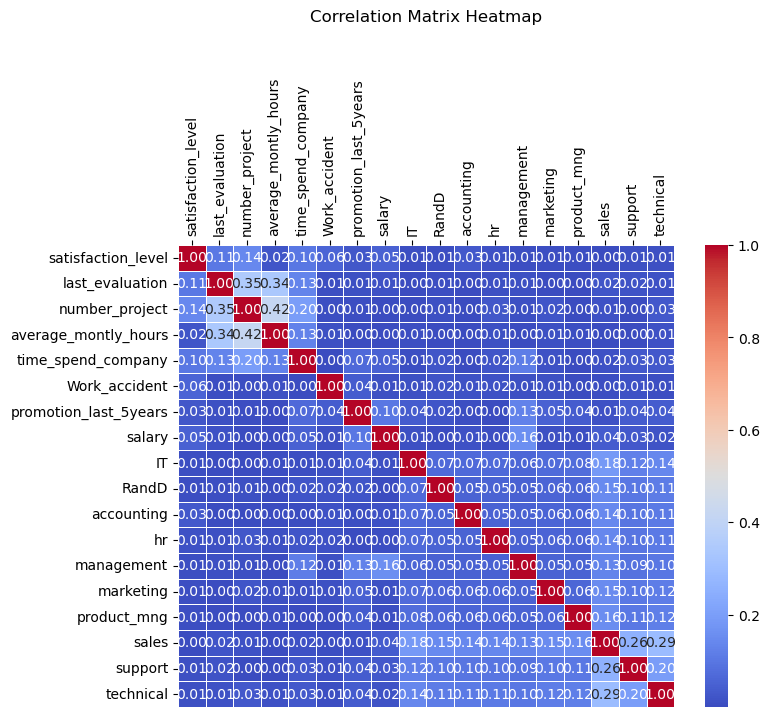

In [11]:
plot_correlation_heatmap(features_df)

From the correlation matrix heatmap, we can draw the following conclusions:
<ul>
    <li>Correlation between features: There is little or no correlation between the features and as such,
    they can be considered independent features. </li>
    <li>Most correlated features: The features which have the highest correlation between them (0.42) are "number_project"
    and "average_monthly_hours"</li>
</ul>

In [12]:
features_df = remove_correlated_features(features_df, 0.9)
features_df.head()
print(features_df.shape)

(14999, 18)


<h2 style="color:gold">Exploratory Data Analysis (EDA)</h2>

In this section, I will try to explore the data more, to understand some feature-target relationships. This section will include:
<ol>
    <li>Check for class balcance</li>
    <li>Perform PCA to identify and visualize clusters (to know if I would be able to find a good model)</li>
    <li>Remove low variance features (if any)</li>
</ol>

In [13]:
# Check for balance in the target variable
target_df.value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

In [14]:
# Statistics of the features
features_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,0.594706,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,0.637183,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Features are of different scales, therefore scaling would be needed during date preprocessing section** 

In [15]:
# Scaled statistics of the features to see the variability of the features
pd.DataFrame(MinMaxScaler().fit_transform(features_df), columns=features_df.columns).describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.360611,0.490889,0.187279,0.144610,0.021268,0.297353,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345
std,0.273220,0.267452,0.246518,0.233379,0.182517,0.351719,0.144281,0.318591,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.200000,0.280374,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,0.400000,0.485981,0.125000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.802198,0.796875,0.600000,0.696262,0.250000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**The standard deviation varies slightly across features, I might consider removing low variance features (if any)** 

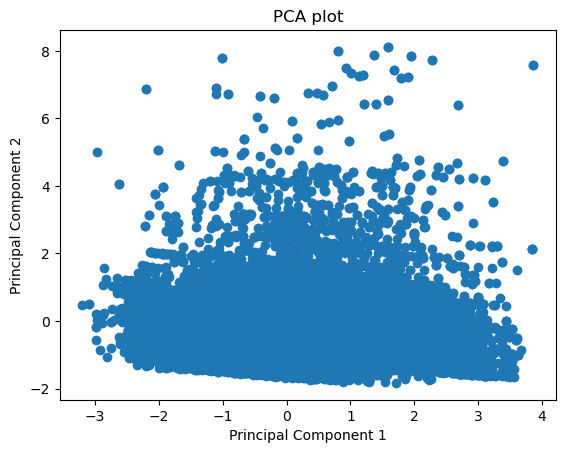

In [16]:
plot_pca(features_df)

**Checking for low variance features, which would probably have less impact on the target** 

In [17]:
features_df = remove_low_variance_features(features_df, 0.01)
print(features_df.shape)
features_df.head()

(14999, 18)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
print(features_df.shape)
features_df.head()

(14999, 18)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


From the EDA analysis, we can draw the following conclusions:
<ul>
    <li>Class Imbalance: There seems to be an imbalance in the class labels (76% for class 0, 24% for class 1)
    and this might affect the model's performance (the model might find it difficult in predicting outcomes effectively)</li>
    <li>Overlapping clusters: The PCA plot shows no distinct (clear) boundaries and this indicates that the features may not
    provide enough information to seperate classes or predict the outcomes effectively</li>
    <li>Low Variance : No feature had variance below the threshold and as such, no feature was removed</li>
</ul>

<h2 style="color:gold">Data Preprocessing</h2>

In this section, I will preprocess the data for training. This section will include:
<ol>
    <li>Scaliing</li>
    <li>Transformation (if required)</li>
    <li>Test-Train Split</li>
</ol>

In [19]:
# Scale the features using MaxMinScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features_df = scaler.fit_transform(features_df)

In [20]:
X = scaled_features_df
y = target_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2 style="color:gold">Model Selection, Feature Engineering and Hyperparameter Optimization</h2>

In this section, I seek to select the best model, features (and/or feature combinations) and hyperparameters. This section will include:
<ol>
    <li>K-fold Cross Validation</li>
    <li>Feature Engineering (Selecting the best combination of features using selectKBest)</li>
    <li>Hyperparameter Optimization (Bayesian Optimization using hyperopt) </li>
</ol>

In [21]:

# Use logistic regression to classify the data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.787


In [22]:
model.score(X_test, y_test)

0.787